# Clustering de Tipos de Usuario
## Modelo funcional con datos simulados

In [1]:
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score

import joblib
import json

%matplotlib inline

## 1. Cargar Datos Preprocesados

In [2]:
df = pd.read_csv('../output/features_for_clustering.csv')

print(f"Datos cargados: {df.shape[0]} usuarios, {df.shape[1]-1} features")
print(f"\nFeatures disponibles:")
print(df.columns.tolist())

df.head()

Datos cargados: 100 usuarios, 10 features

Features disponibles:
['user_id', 'completion_rate', 'avg_frustration', 'avg_visual_attention', 'avg_visual_fatigue', 'distraction_events_per_hour', 'drowsiness_events_per_hour', 'avg_pause_count', 'intervention_count_per_activity', 'avg_engagement_score', 'preference_easy_activities']


,user_id,completion_rate,avg_frustration,avg_visual_attention,avg_visual_fatigue,distraction_events_per_hour,drowsiness_events_per_hour,avg_pause_count,intervention_count_per_activity,avg_engagement_score,preference_easy_activities
0,1001,0.8556,0.196859,77.822889,0.3417,0.0589,0.0074,2.0444,2.2000,1.8652,1.0000
1,1002,0.8706,0.198501,77.732073,0.3571,0.0528,0.0061,2.0471,1.9412,1.9135,0.9524
2,1003,0.7935,0.220783,77.558021,0.3461,0.0425,0.0053,1.9891,1.7609,1.8697,0.8000
3,1004,0.8191,0.226079,77.762935,0.3149,0.0431,0.0051,2.0106,2.0106,1.8903,0.8462
4,1005,0.8000,0.216905,77.287733,0.3388,0.0265,0.0037,2.0471,1.6941,1.8833,0.8750


## 2. Preparación de Features

In [3]:
feature_cols = [col for col in df.columns if col != 'user_id']
X = df[feature_cols].values
user_ids = df['user_id'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features normalizadas: {X_scaled.shape}")
print(f"\nMedia después de normalización: {X_scaled.mean(axis=0).round(3)}")
print(f"Desviación estándar después de normalización: {X_scaled.std(axis=0).round(3)}")

Features normalizadas: (100, 10)

Media después de normalización: [-0.  0. -0. -0.  0.  0. -0.  0. -0.  0.]
Desviación estándar después de normalización: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 3. Determinar Número Óptimo de Clusters (Método del Codo)

c:\Users\JulioC\Desktop\proyecto\ml\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\JulioC\Desktop\proyecto\ml\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\JulioC\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 546, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\JulioC\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1022, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users

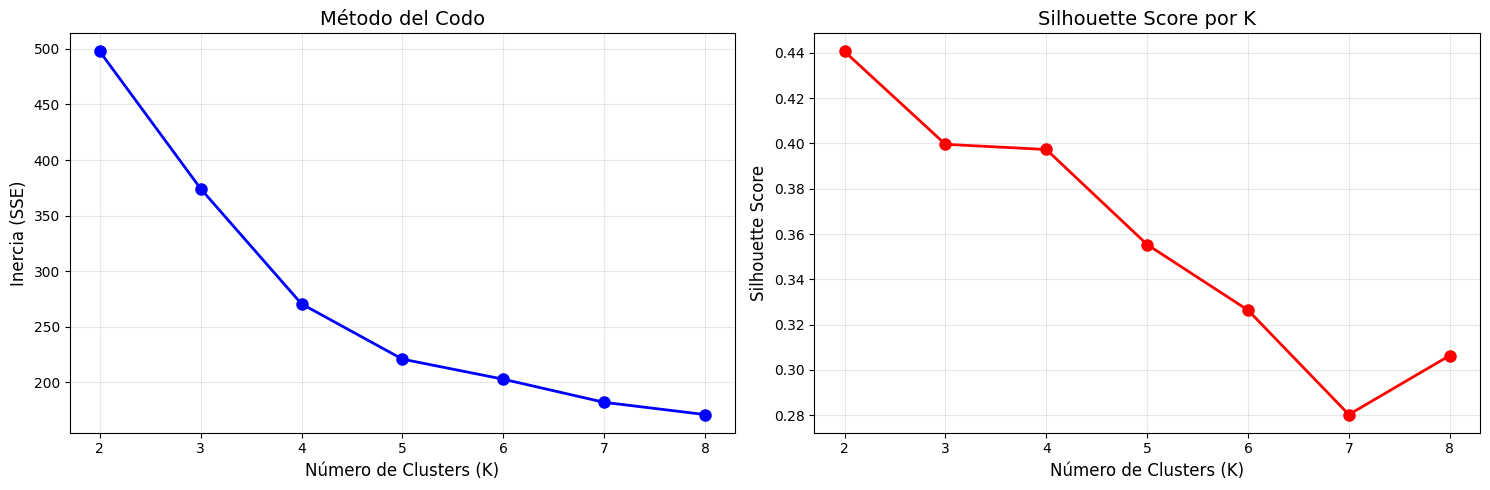


Métricas por número de clusters:
   K     Inercia  Silhouette
0  2  497.662362    0.440625
1  3  374.245665    0.399623
2  4  270.675639    0.397347
3  5  220.991703    0.355353
4  6  202.933340    0.326370
5  7  182.149244    0.280265
6  8  171.126212    0.306339


In [4]:
inertias = []
silhouette_scores = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Número de Clusters (K)', fontsize=12)
ax1.set_ylabel('Inercia (SSE)', fontsize=12)
ax1.set_title('Método del Codo', fontsize=14)
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Número de Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score por K', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/elbow_silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMétricas por número de clusters:")
metrics_df = pd.DataFrame({
    'K': list(K_range),
    'Inercia': inertias,
    'Silhouette': silhouette_scores
})
print(metrics_df)

## 4. Entrenar Modelo con K Óptimo

In [5]:
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df['cluster'] = cluster_labels

silhouette_avg = silhouette_score(X_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)

print(f"Modelo entrenado con K={optimal_k}")
print(f"\nMétricas del modelo:")
print(f"  - Silhouette Score: {silhouette_avg:.3f}")
print(f"  - Davies-Bouldin Index: {davies_bouldin:.3f} (menor es mejor)")
print(f"  - Inercia: {kmeans_final.inertia_:.2f}")

print(f"\nDistribución de usuarios por cluster:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {count} usuarios ({percentage:.1f}%)")

Modelo entrenado con K=4

Métricas del modelo:
  - Silhouette Score: 0.397
  - Davies-Bouldin Index: 0.734 (menor es mejor)
  - Inercia: 270.68

Distribución de usuarios por cluster:
  Cluster 0: 25 usuarios (25.0%)
  Cluster 1: 45 usuarios (45.0%)
  Cluster 2: 1 usuarios (1.0%)
  Cluster 3: 29 usuarios (29.0%)


## 5. Análisis de Centroides

Centroides de los clusters (valores originales):
           completion_rate  avg_frustration  avg_visual_attention  \
Cluster 0            0.826            0.207                77.501   
Cluster 1            0.435            0.380                58.933   
Cluster 2            0.717            0.315                69.277   
Cluster 3            0.703            0.312                70.135   

           avg_visual_fatigue  distraction_events_per_hour  \
Cluster 0               0.335                        0.035   
Cluster 1               0.329                        0.042   
Cluster 2               0.344                        0.282   
Cluster 3               0.333                        0.046   

           drowsiness_events_per_hour  avg_pause_count  \
Cluster 0                       0.004            2.006   
Cluster 1                       0.001            8.111   
Cluster 2                       0.015            4.830   
Cluster 3                       0.002            4.466   

   

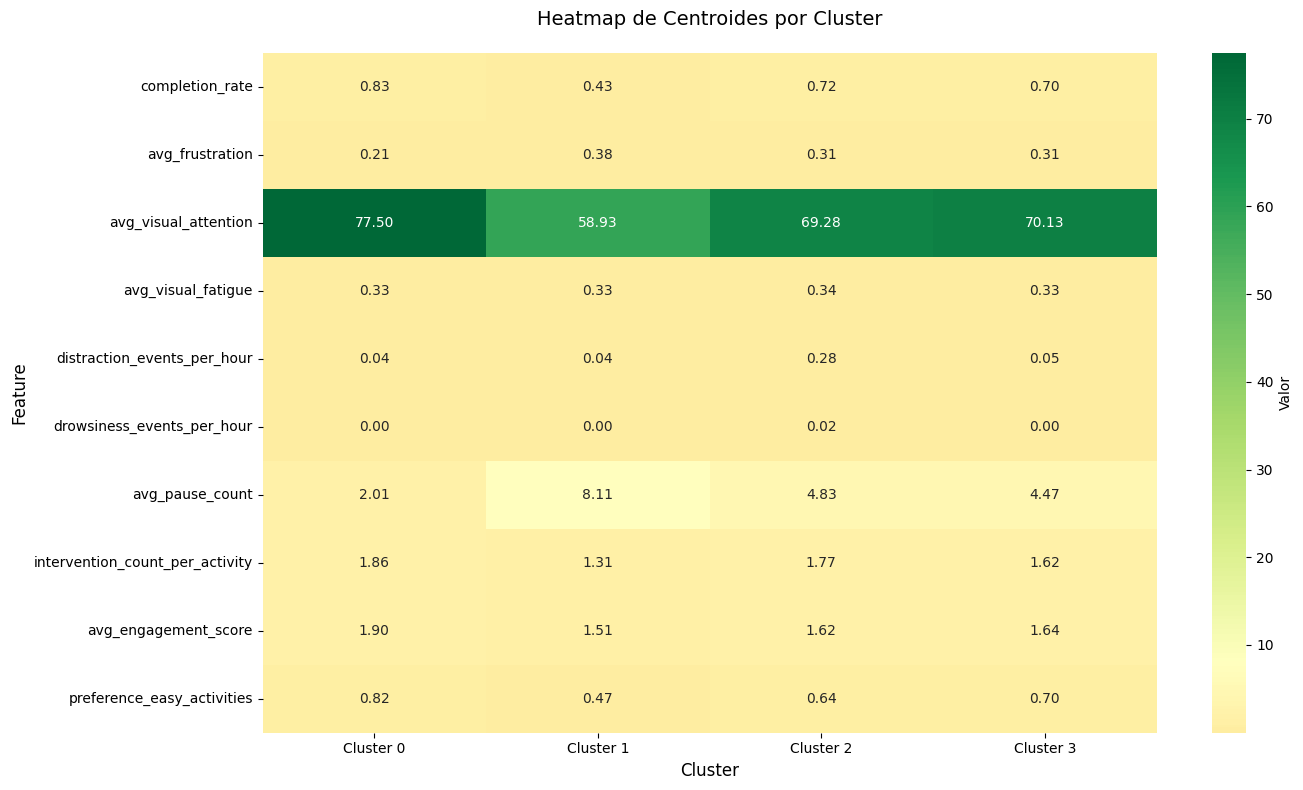

In [6]:
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_original, columns=feature_cols)
centroids_df.index = [f'Cluster {i}' for i in range(optimal_k)]

print("Centroides de los clusters (valores originales):")
print(centroids_df.round(3))

plt.figure(figsize=(14, 8))
sns.heatmap(centroids_df.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=centroids_df.values.mean(), cbar_kws={'label': 'Valor'})
plt.title('Heatmap de Centroides por Cluster', fontsize=14, pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../output/centroids_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Interpretación y Etiquetado de Clusters

In [7]:
cluster_stats = df.groupby('cluster')[feature_cols].mean()

cluster_labels_map = {}

for cluster_id in range(optimal_k):
    stats = cluster_stats.loc[cluster_id]
    
    if stats['completion_rate'] > 0.7 and stats['avg_frustration'] < 0.45:
        label = "Rápido Visual"
        description = "Alta tasa de completitud, baja frustración, buena atención visual"
    elif stats['avg_frustration'] > 0.55 and stats['completion_rate'] > 0.55:
        label = "Lector Constante"
        description = "Tolera frustración, completa actividades, pausas estratégicas"
    elif stats['distraction_events_per_hour'] > 6 and stats['completion_rate'] < 0.55:
        label = "Disperso Visual"
        description = "Alta distracción, abandona actividades complejas, muchas pausas"
    else:
        label = "Fatigado Visual"
        description = "Fatiga visual, pausas frecuentes, mejor en sesiones cortas"
    
    cluster_labels_map[cluster_id] = {
        'name': label,
        'description': description
    }

print("\nETIQUETAS DE CLUSTERS:")
print("="*60)
for cluster_id, info in cluster_labels_map.items():
    count = (cluster_labels == cluster_id).sum()
    percentage = (count / len(cluster_labels)) * 100
    print(f"\nCluster {cluster_id}: {info['name']}")
    print(f"  Usuarios: {count} ({percentage:.1f}%)")
    print(f"  Descripción: {info['description']}")
    print(f"  Características clave:")
    print(f"    - Completion rate: {cluster_stats.loc[cluster_id, 'completion_rate']:.2%}")
    print(f"    - Frustración promedio: {cluster_stats.loc[cluster_id, 'avg_frustration']:.3f}")
    print(f"    - Atención visual: {cluster_stats.loc[cluster_id, 'avg_visual_attention']:.1f}%")
    print(f"    - Distracciones/hora: {cluster_stats.loc[cluster_id, 'distraction_events_per_hour']:.2f}")
    print(f"    - Pausas promedio: {cluster_stats.loc[cluster_id, 'avg_pause_count']:.2f}")


ETIQUETAS DE CLUSTERS:

Cluster 0: Rápido Visual
  Usuarios: 25 (25.0%)
  Descripción: Alta tasa de completitud, baja frustración, buena atención visual
  Características clave:
    - Completion rate: 82.57%
    - Frustración promedio: 0.207
    - Atención visual: 77.5%
    - Distracciones/hora: 0.04
    - Pausas promedio: 2.01

Cluster 1: Fatigado Visual
  Usuarios: 45 (45.0%)
  Descripción: Fatiga visual, pausas frecuentes, mejor en sesiones cortas
  Características clave:
    - Completion rate: 43.49%
    - Frustración promedio: 0.380
    - Atención visual: 58.9%
    - Distracciones/hora: 0.04
    - Pausas promedio: 8.11

Cluster 2: Rápido Visual
  Usuarios: 1 (1.0%)
  Descripción: Alta tasa de completitud, baja frustración, buena atención visual
  Características clave:
    - Completion rate: 71.70%
    - Frustración promedio: 0.315
    - Atención visual: 69.3%
    - Distracciones/hora: 0.28
    - Pausas promedio: 4.83

Cluster 3: Rápido Visual
  Usuarios: 29 (29.0%)
  Descripción

## 7. Visualización con PCA

Varianza explicada por componentes PCA:
  PC1: 64.18%
  PC2: 14.59%
  Total: 78.78%


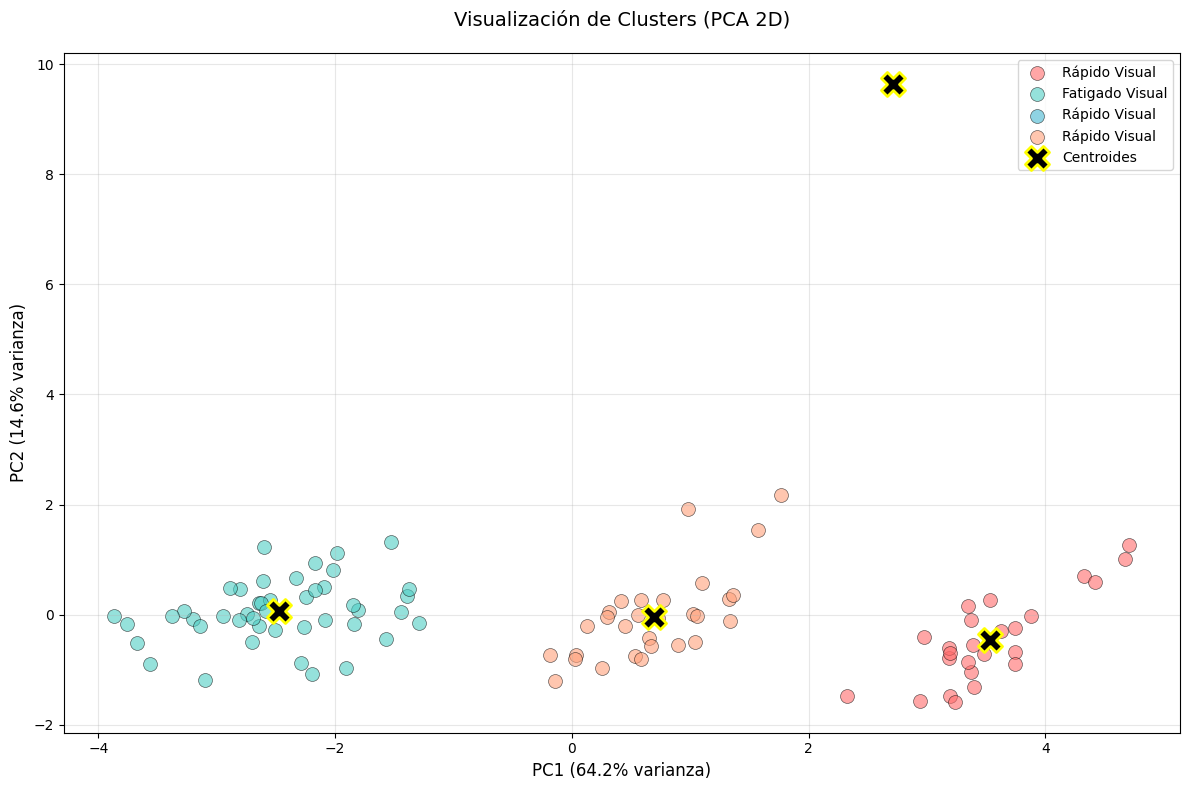

In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Varianza explicada por componentes PCA:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  Total: {pca.explained_variance_ratio_.sum():.2%}")

plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for cluster_id in range(optimal_k):
    mask = cluster_labels == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=colors[cluster_id], label=cluster_labels_map[cluster_id]['name'],
                alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

centroids_pca = pca.transform(centroids_scaled)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='black', marker='X', s=300, edgecolors='yellow', linewidth=2,
            label='Centroides', zorder=5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)', fontsize=12)
plt.title('Visualización de Clusters (PCA 2D)', fontsize=14, pad=20)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../output/clusters_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Silhouette Plot

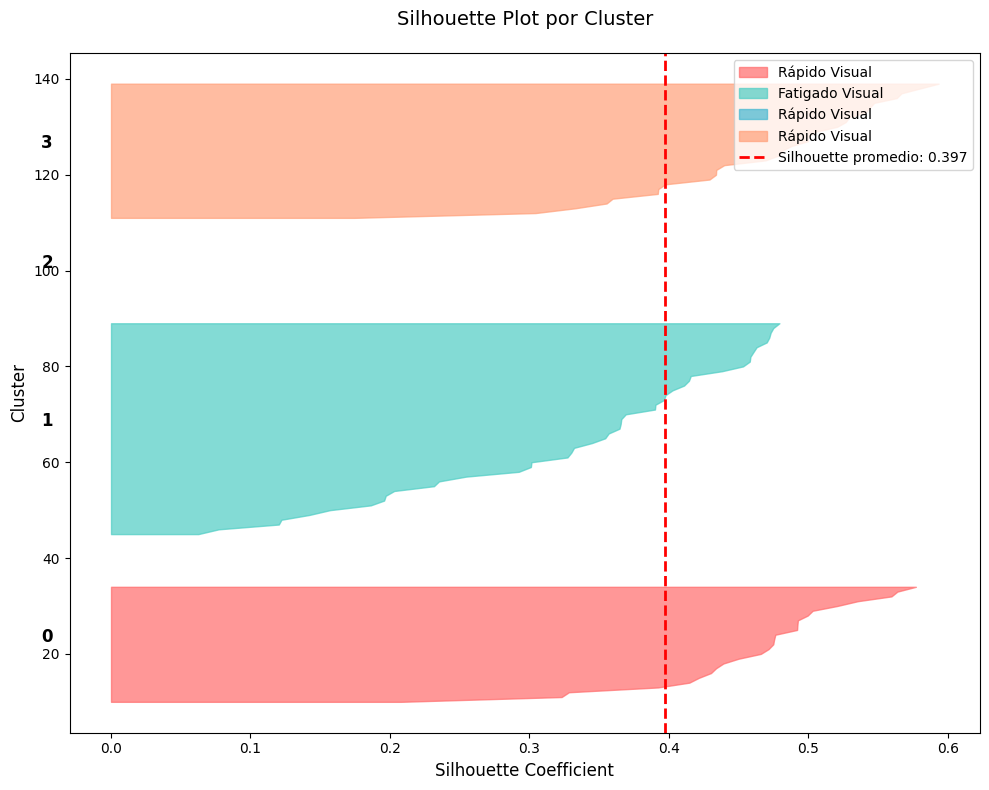

In [9]:
silhouette_vals = silhouette_samples(X_scaled, cluster_labels)

fig, ax = plt.subplots(figsize=(10, 8))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      alpha=0.7, color=colors[i],
                      label=cluster_labels_map[i]['name'])
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12, fontweight='bold')
    
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
           label=f'Silhouette promedio: {silhouette_avg:.3f}')
ax.set_xlabel("Silhouette Coefficient", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)
ax.set_title("Silhouette Plot por Cluster", fontsize=14, pad=20)
ax.legend(loc='best')
plt.tight_layout()
plt.savefig('../output/silhouette_plot.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Comparación de Clusters

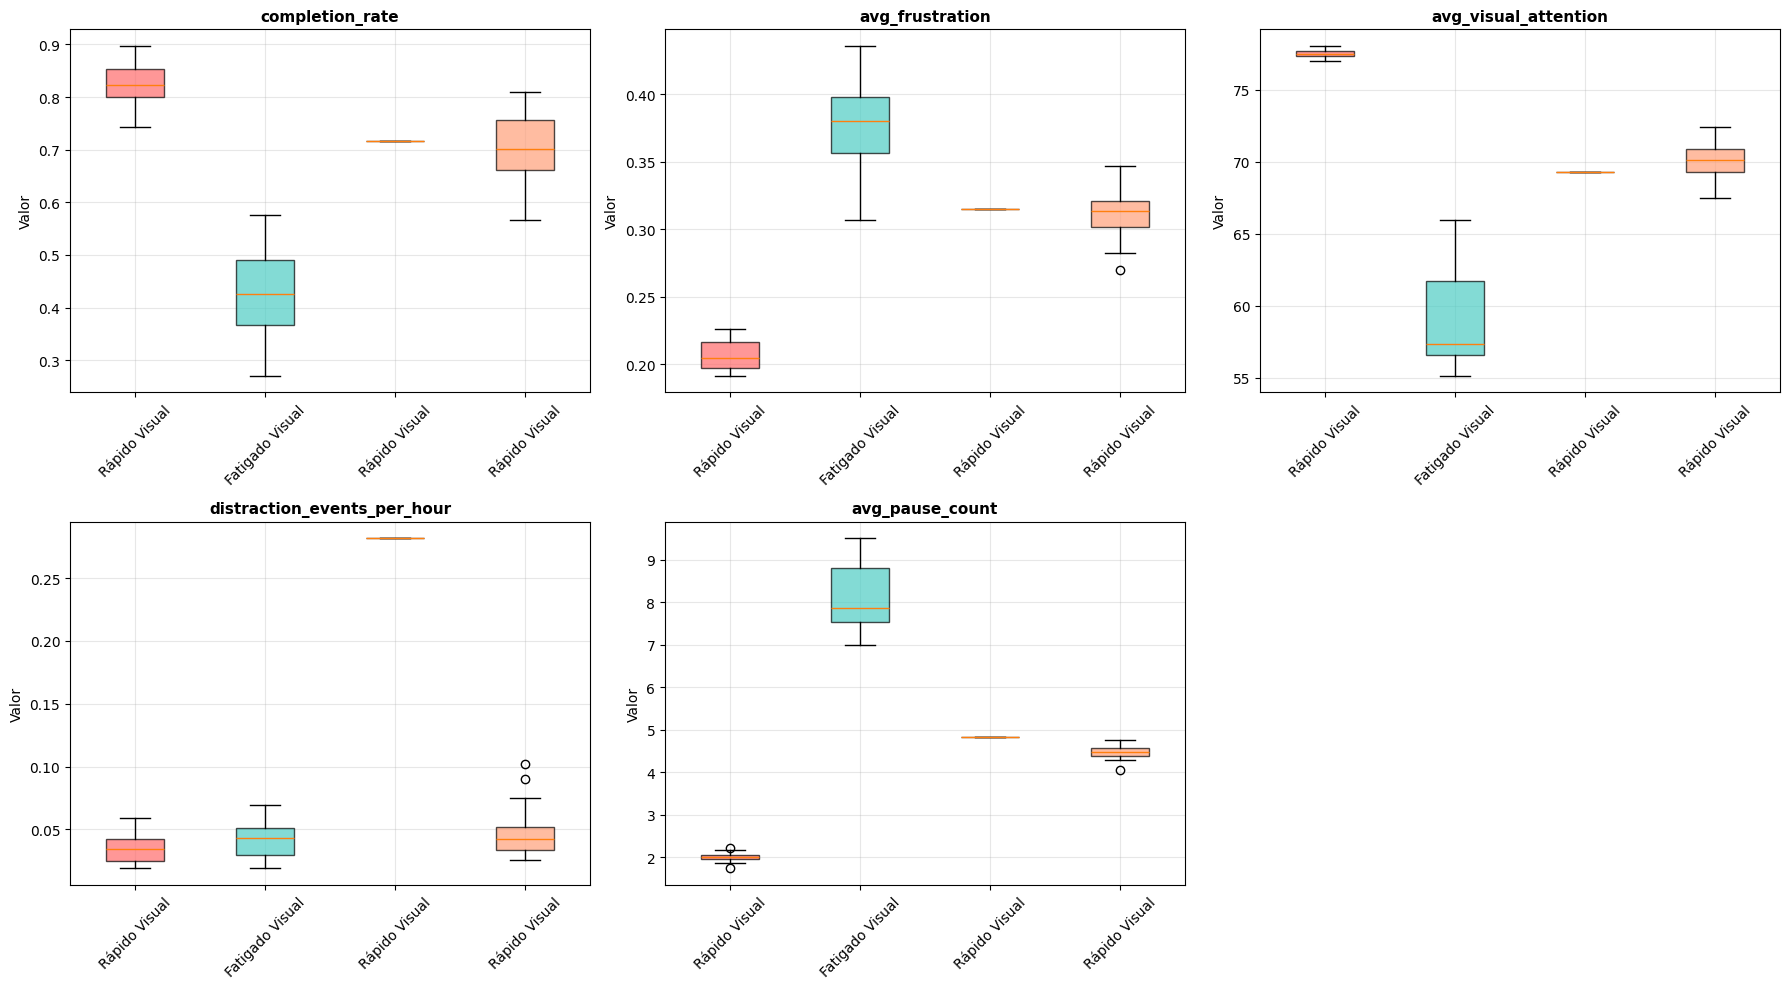

In [10]:
comparison_features = [
    'completion_rate',
    'avg_frustration',
    'avg_visual_attention',
    'distraction_events_per_hour',
    'avg_pause_count'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(comparison_features):
    data_by_cluster = [df[df['cluster'] == i][feature].values for i in range(optimal_k)]
    
    bp = axes[idx].boxplot(data_by_cluster, labels=[cluster_labels_map[i]['name'] for i in range(optimal_k)],
                            patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_title(feature, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('../output/clusters_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Guardar Modelo

In [11]:
joblib.dump(kmeans_final, '../models/user_type_classifier.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

labels_export = {str(k): v['name'] for k, v in cluster_labels_map.items()}
with open('../models/cluster_labels.json', 'w') as f:
    json.dump(labels_export, f, indent=2)

model_metadata = {
    'n_clusters': optimal_k,
    'features': feature_cols,
    'silhouette_score': float(silhouette_avg),
    'davies_bouldin_score': float(davies_bouldin),
    'inertia': float(kmeans_final.inertia_),
    'cluster_distribution': {str(k): int(v) for k, v in cluster_counts.items()},
    'trained_on': pd.Timestamp.now().isoformat()
}

with open('../models/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

df.to_csv('../output/users_with_clusters.csv', index=False)

print("Modelo guardado exitosamente:")
print("  - models/user_type_classifier.pkl")
print("  - models/scaler.pkl")
print("  - models/cluster_labels.json")
print("  - models/model_metadata.json")
print("  - output/users_with_clusters.csv")

Modelo guardado exitosamente:
  - models/user_type_classifier.pkl
  - models/scaler.pkl
  - models/cluster_labels.json
  - models/model_metadata.json
  - output/users_with_clusters.csv


## 11. Prueba de Predicción

In [12]:
test_user = df.iloc[0][feature_cols].values.reshape(1, -1)
test_user_scaled = scaler.transform(test_user)
predicted_cluster = kmeans_final.predict(test_user_scaled)[0]

print(f"Usuario de prueba (user_id: {df.iloc[0]['user_id']}):")
print(f"\nFeatures:")
for feat, val in zip(feature_cols, test_user[0]):
    print(f"  {feat}: {val:.3f}")

print(f"\nPredicción:")
print(f"  Cluster ID: {predicted_cluster}")
print(f"  Cluster Name: {cluster_labels_map[predicted_cluster]['name']}")
print(f"  Descripción: {cluster_labels_map[predicted_cluster]['description']}")

Usuario de prueba (user_id: 1001.0):

Features:
  completion_rate: 0.856
  avg_frustration: 0.197
  avg_visual_attention: 77.823
  avg_visual_fatigue: 0.342
  distraction_events_per_hour: 0.059
  drowsiness_events_per_hour: 0.007
  avg_pause_count: 2.044
  intervention_count_per_activity: 2.200
  avg_engagement_score: 1.865
  preference_easy_activities: 1.000

Predicción:
  Cluster ID: 0
  Cluster Name: Rápido Visual
  Descripción: Alta tasa de completitud, baja frustración, buena atención visual
